# Investigates different options for preprocessing and ML

# Model

In [27]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time


sns.set_theme(style = "whitegrid")
plt.rcParams.update({
    'font.size': 8,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
})


In [28]:
PLOT = True

# Get Dataset

In [29]:
with open(f"Simulation_Results_10/Loads_Network_1_Feeder_1.npy", 'rb') as f:
    Dataset = np.load(f, allow_pickle = True)

with open(f"Simulation_Results_10/Targets_Network_1_Feeder_1.npy", "rb") as f:
    Targets = np.load(f, allow_pickle = True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(Dataset, 230*Targets, test_size=0.3, shuffle = False)

In [31]:
phi_n = np.random.uniform(0.9,0.98,len(X_train[:,0]))
phi_n

array([0.91885871, 0.9666609 , 0.91848278, ..., 0.96209028, 0.91806037,
       0.92187037])

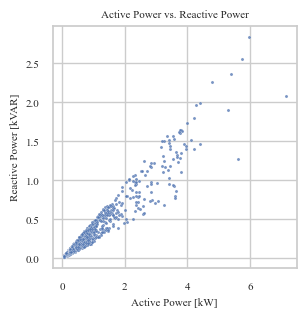

In [32]:
if PLOT:
    fig, axes = plt.subplots(1,1, figsize = (3.15,3.15))
    plt.title(f"Active Power vs. Reactive Power", fontsize = 8)
    plt.ylabel("Reactive Power [kVAR]", fontsize = 8)
    plt.xlabel("Active Power [kW]", fontsize = 8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    sns.scatterplot(x = X_train[:,0], y = X_train[:,0]*np.tan(np.arccos(phi_n)), s = 5, alpha = 0.75)

In [33]:
names_list = []
for i in range(0,55):
    names_list.append(f"{i}")
X_train_df = pd.DataFrame(X_train, columns = names_list)
y_train_df =  pd.DataFrame(y_train, columns = ["y"])

X_test_df = pd.DataFrame(X_test, columns = names_list)
y_test_df =  pd.DataFrame(y_test, columns = ["y"])

Text(0, 0.5, 'Voltage')

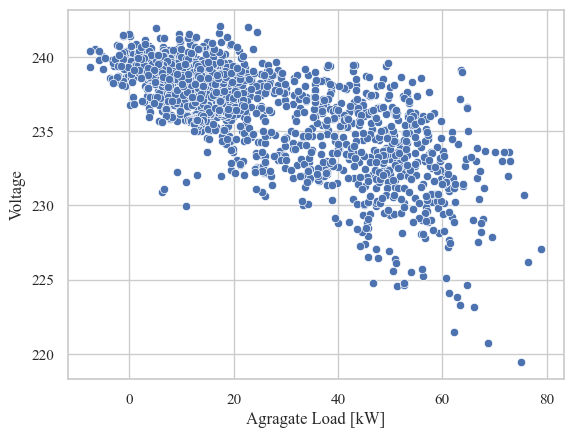

In [34]:
# aggregate agisngt voltage
sns.scatterplot(x = np.array(X_train_df.sum(axis = 1)), y = np.array(y_train_df)[:,0])
plt.xlabel("Agragate Load [kW]")
plt.ylabel("Voltage")

38
0.12979992868245763


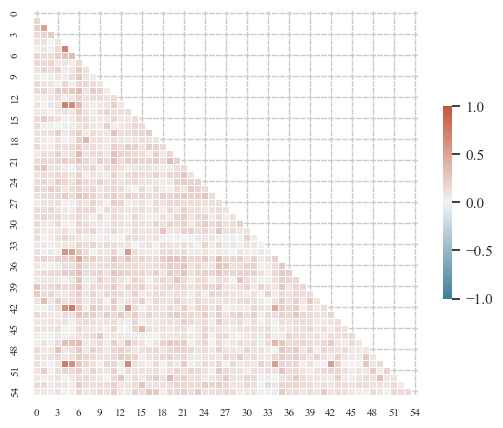

In [35]:
if PLOT:
    fig, ax = plt.subplots(1,1, figsize = (6.3,5))
    # Compute the correlation matrix
    corr = X_train_df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    Count, Average, Number = 0,0,0
    for i in range(55):
        for j in range(i):
            if i == j:
                continue
            if np.abs(corr.iloc[i,j]) > 0.3:
                Count+=1
            Average += np.abs(corr.iloc[i,j])
            Number +=1
    print(Count)
    print(Average/Number)
    
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.rcParams['font.family'] = 'Times New Roman'


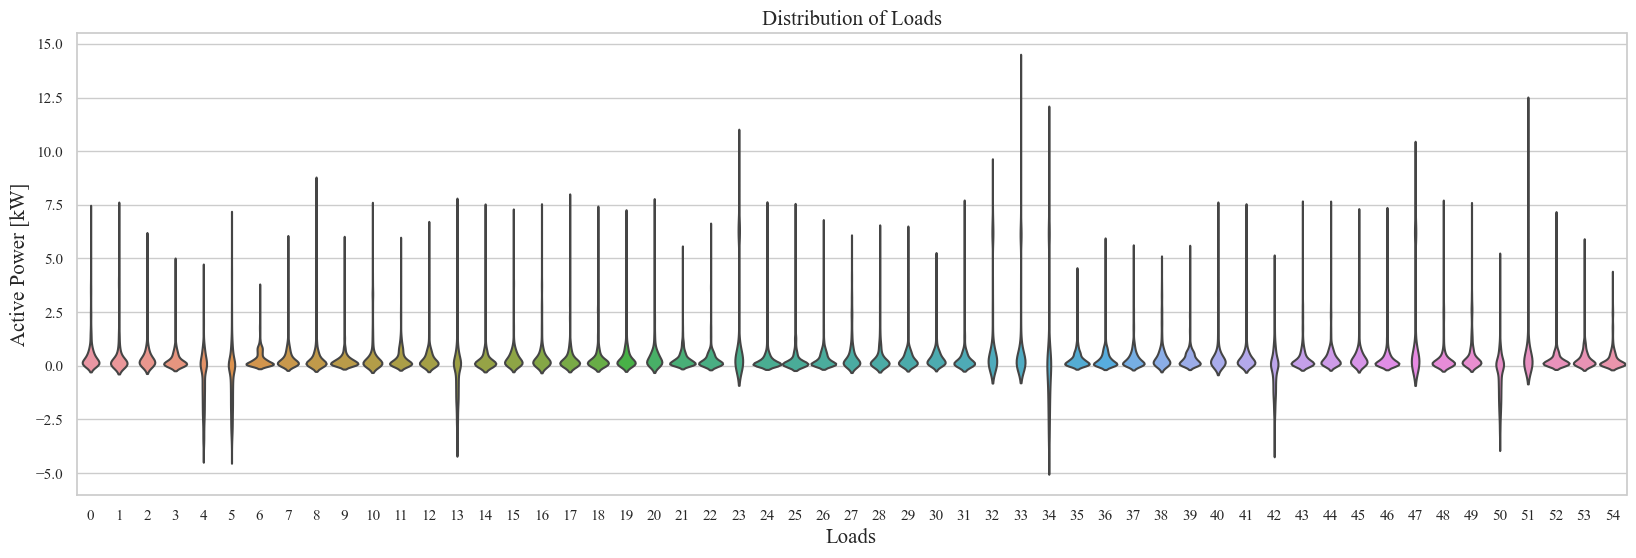

In [36]:
if PLOT:
    # Set up the matplotlib figure
    f, axes = plt.subplots(figsize=(20, 6))
    # Using seaborn to create boxplots for each column
    sns.violinplot(data=X_train_df.iloc[:,:55], width=1,inner = None)
    xyz = X_train_df.iloc[:, :55].copy()
    plt.title(f"Distribution of Loads",fontsize = 15)
    plt.xlabel("Loads",fontsize = 15)
    plt.ylabel("Active Power [kW]",fontsize = 15)

In [37]:
X_df_transformed = pd.DataFrame(X_train, columns = names_list)

# Modelling

In [38]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.model_selection import RepeatedKFold


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson
from sklearn.neural_network import MLPRegressor



## Training different models

## Pipline

In [39]:
regressor = TransformedTargetRegressor(
    regressor = linear_model.LinearRegression(),
    transformer = StandardScaler(with_mean = True, with_std = True)
    )
# Add to pipeline to add c&s or PT and c&s
#("preprocess_cs",StandardScaler(with_mean = True, with_std = True)),
#("preprocess_tr",PowerTransformer(method = "yeo-johnson")),
pipeline = Pipeline(
    steps = [
        ("target_transform", regressor)
    ])


In [40]:
pipeline

Pipeline(steps=[('target_transform',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=StandardScaler()))])

C:\Users\OMalleyAG\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


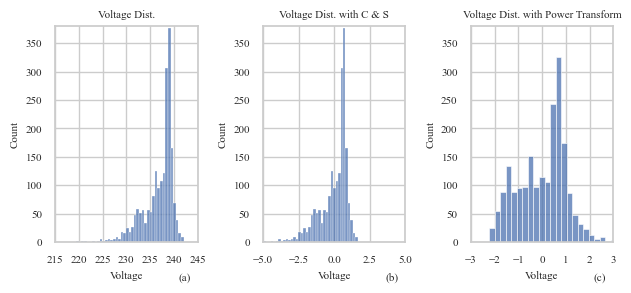

In [41]:
# Voltage Distribution
if PLOT:
    ss = StandardScaler(with_mean = True, with_std = True).fit(y_train.reshape(-1, 1))
    v_transformed = ss.transform(y_train.reshape(-1, 1))

    p = PowerTransformer(standardize = False).fit(y_train.reshape(-1, 1))
    p_t = p.transform(y_train.reshape(-1, 1))
    sp = StandardScaler(with_mean = True, with_std = True).fit(p_t)
    v_p_transformed = sp.transform(p_t)
    
    fig, ax = plt.subplots(1,3, figsize = (6.3,3))
    
    sns.histplot(y_train, ax = ax[0])
    ax[0].set_ylabel("Count", fontsize = 8)
    ax[0].set_xlabel("Voltage", fontsize = 8)
    ax[0].set_title(f"Voltage Dist.", fontsize = 8)
    ax[0].set_xlim(215,245)
    ax[0].set_ylim(0,380)
    ax[0].set_xticks(range(215,250,5))
    ax[0].tick_params(axis='both', which='major', labelsize=8)
    ax[0].text(0.95, -0.19, "(a)", verticalalignment='bottom', horizontalalignment='right',
            transform=ax[0].transAxes, fontsize=8)
    
    sns.histplot(v_transformed.values.flatten(), ax = ax[1])
    ax[1].set_ylabel("Count", fontsize = 8)
    ax[1].set_xlabel("Voltage", fontsize = 8)
    ax[1].set_title(f"Voltage Dist. with C & S", fontsize = 8)
    ax[1].set_xlim(-5,5)
    ax[1].set_ylim(0,380)
    ax[1].set_xticks([-5,-2.5,0,2.5,5])
    ax[1].tick_params(axis='both', which='major', labelsize=8)
    ax[1].text(0.95, -0.19, "(b)", verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes, fontsize=8)
    
    sns.histplot(v_p_transformed.values.flatten(), ax = ax[2])
    ax[2].set_ylabel("Count", fontsize = 8)
    ax[2].set_xlabel("Voltage", fontsize = 8)
    ax[2].set_title(f"Voltage Dist. with Power Transform", fontsize = 8)
    ax[2].set_xlim(-3,3)
    ax[2].set_ylim(0,380)
    ax[2].set_xticks(range(-3,4))
    ax[2].tick_params(axis='both', which='major', labelsize=8)
    ax[2].text(0.95, -0.19, "(c)", verticalalignment='bottom', horizontalalignment='right',
        transform=ax[2].transAxes, fontsize=8)

    plt.tight_layout()
    plt.rcParams['font.family'] = 'Times New Roman'

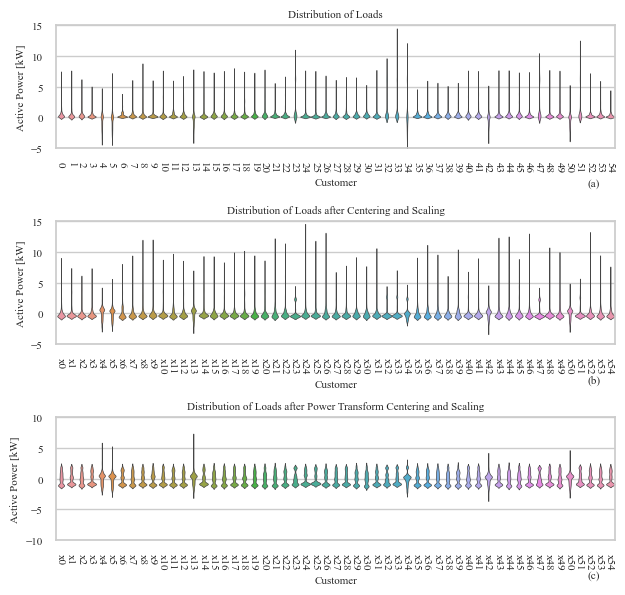

In [42]:
if PLOT:
    cs_scaler = StandardScaler(with_mean = True, with_std = True)
    cs_scaler.fit(X_train)
    X_centered = cs_scaler.transform(X_train)
    
    yeo = PowerTransformer(method = "yeo-johnson")
    yeo.fit(X_train)
    X_centered_trans = yeo.transform(X_train)
    
    f, axes = plt.subplots(3,1,figsize=(6.3, 6))
    #f, axes = plt.subplots(3,1,figsize=(15, 6))
    # Using seaborn to create boxplots for each column
    sns.violinplot(data=X_train, ax = axes[0], width=1,inner = None, linewidth = 0.5)
    axes[0].set_title("Distribution of Loads",fontsize = 8)
    axes[0].set_xlabel("Customer",fontsize = 8)
    axes[0].set_ylabel("Active Power [kW]",fontsize = 8)
    axes[0].set_ylim(-5,15)
    axes[0].set_yticks(range(-5,20,5))
    axes[0].tick_params(axis='both', which='major', labelsize=8)
    axes[0].text(0.95, -0.25, "(a)", transform=axes[0].transAxes, fontsize=8, va='top')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=-90)

    sns.violinplot(data=X_centered, ax = axes[1], width=1,inner = None, linewidth = 0.5)
    axes[1].set_title(f"Distribution of Loads after Centering and Scaling",fontsize = 8)
    axes[1].set_xlabel("Customer",fontsize = 8)
    axes[1].set_ylabel("Active Power [kW]",fontsize = 8)
    axes[1].set_ylim(-5,15)
    axes[1].set_yticks(range(-5,20,5))
    axes[1].tick_params(axis='both', which='major', labelsize=8)
    axes[1].text(0.95, -0.25, "(b)", transform=axes[1].transAxes, fontsize=8, va='top')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=-90)
    
    sns.violinplot(data=X_centered_trans, ax = axes[2], width=1,inner = None, linewidth = 0.5)
    axes[2].set_title(f"Distribution of Loads after Power Transform Centering and Scaling",fontsize = 8)
    axes[2].set_xlabel("Customer",fontsize = 8)
    axes[2].set_ylabel("Active Power [kW]",fontsize = 8)
    axes[2].set_ylim(-10,10)
    axes[2].set_yticks(range(-10,15,5))
    axes[2].tick_params(axis='both', which='major', labelsize=8)
    axes[2].text(0.95, -0.25, "(c)", transform=axes[2].transAxes, fontsize=8, va='top')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=-90)
    
    plt.tight_layout()
    plt.rcParams['font.family'] = 'Times New Roman'

In [43]:
"""# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "model__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train_df, y_train_df)"""

'# Parameters of pipelines can be set using \'__\' separated parameter names:\nparam_grid = {\n    "model__C": np.logspace(-4, 4, 4),\n}\nsearch = GridSearchCV(pipe, param_grid, n_jobs=2)\nsearch.fit(X_train_df, y_train_df)'

# Hyperparameter Tuning

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared = False), greater_is_better=False)

## Linear SVM

In [45]:
pipeline.set_params(target_transform__regressor = SVR(kernel = "linear"))

param_grid = {
'target_transform__regressor__C': np.linspace(1, 10, 10),
'target_transform__regressor__epsilon': np.linspace(0, 0.1, 20)
}

grid_search_lin = GridSearchCV(pipeline, param_grid, cv=RepeatedKFold(n_splits=5, n_repeats=2), scoring=rmse_scorer, n_jobs=-1, verbose = 2)
grid_search_lin.fit(X_train, y_train)
results_lin_svm = pd.DataFrame(grid_search_lin.cv_results_)
results_lin_svm["mean_test_score"] = -1*results_lin_svm["mean_test_score"]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = sns.pointplot(x='param_target_transform__regressor__C', y='mean_test_score', hue='param_target_transform__regressor__epsilon', data=results_lin_svm, palette = "viridis")

plt.title('Linear SVM Hyperparameter Tuning')
plt.xlabel('C')
plt.ylabel('Root Mean Squared Error')
plt.legend(title='Epsilon', loc='upper right')
plt.show()

SVM_linear_params = grid_search_lin.best_params_
print(grid_search_lin.best_params_)

## SVM Radial Basis Function

In [ ]:
# gamma is chosen analytically
pipeline.set_params(target_transform__regressor = SVR(kernel = "rbf"))

param_grid = {
'target_transform__regressor__C': np.linspace(1, 10, 20),
'target_transform__regressor__epsilon': np.linspace(0, 0.01, 20)
}

grid_search_rbf = GridSearchCV(pipeline, param_grid, cv=RepeatedKFold(n_splits=5, n_repeats=2), scoring=rmse_scorer, n_jobs=-1, verbose = 2)
grid_search_rbf.fit(X_train, y_train)
results_rbf = pd.DataFrame(grid_search_rbf.cv_results_)
results_rbf["mean_test_score"] = -1*results_rbf["mean_test_score"]



In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = sns.pointplot(x='param_target_transform__regressor__C', y='mean_test_score', hue='param_target_transform__regressor__epsilon', data=results_rbf, palette = "viridis")

plt.title('RBF SVM Hyperparameter Tuning')
plt.xlabel('C')
plt.ylabel('Negative Root Mean Squared Error')
plt.legend(title='Epsilon')
plt.show()

SVM_rbf_params = grid_search_rbf.best_params_
print(grid_search_rbf.best_params_)

## Histogram Gadient Boosting Regression

In [ ]:
pipeline.set_params(target_transform__regressor = HistGradientBoostingRegressor(max_iter = 500))

param_grid = {
'target_transform__regressor__learning_rate': np.linspace(0.01, 0.3, 20),
'target_transform__regressor__l2_regularization': np.linspace(0, 5, 3)
}

grid_search_hist = GridSearchCV(pipeline, param_grid, cv=RepeatedKFold(n_splits=5, n_repeats=2), scoring=rmse_scorer, n_jobs=-1, verbose = 2)
grid_search_hist.fit(X_train, y_train)
results_hist = pd.DataFrame(grid_search_hist.cv_results_)
results_hist["mean_test_score"] = -1*results_hist["mean_test_score"]


hist_grad_boost_params = grid_search_hist.best_params_
print(grid_search_hist.best_params_)


In [ ]:
fig = plt.figure(figsize=(6.3, 3))
ax = sns.pointplot(x='param_target_transform__regressor__learning_rate', y='mean_test_score', errorbar = 'sd', hue='param_target_transform__regressor__l2_regularization', data=results_hist, palette = "viridis")

plt.title('Histogram Gradient Boosting Regressor Hyperparameter Tuning',fontsize = 8)
plt.xlabel('Learning rate',fontsize = 8)
ax.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_xticklabels()],fontsize = 8)
ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()],fontsize = 8)
plt.ylabel('Root Mean Squared Error',fontsize = 8)
leg = plt.legend(title='l2 Regularisation', fontsize = 8)
leg.get_title().set_fontsize('8')
plt.savefig("Images/HistGradBoost_Tuning.svg")

# Neural Network Optimisation

In [ ]:
pipeline.set_params(target_transform__regressor = MLPRegressor())

param_grid = {
'target_transform__regressor__learning_rate_init': np.linspace(0.001, 0.1, 20),
'target_transform__regressor__alpha': np.linspace(0.00001, 0.001, 20),
'target_transform__regressor__hidden_layer_sizes': [[25,], [50,],[100,],[50,50,]]   
}

grid_search_nn = GridSearchCV(pipeline, param_grid, cv=RepeatedKFold(n_splits=10, n_repeats=5), scoring=rmse_scorer, n_jobs=-1, verbose = 2)
grid_search_nn.fit(X_train, y_train)
results_nn = pd.DataFrame(grid_search_nn.cv_results_)
results_nn["mean_test_score"] = -1*results_nn["mean_test_score"]

NN_optimal_params = grid_search_nn.best_params_
print(grid_search_nn.best_params_)

In [ ]:
results_nn['density_str'] = results_nn['param_target_transform__regressor__hidden_layer_sizes'].astype(str)
g = sns.FacetGrid(results_nn, row='density_str', height=3, aspect=4, palette = "viridis")

# Map the pointplot onto the grid, specifying x, y, and hue
g.map(sns.pointplot, 'param_target_transform__regressor__learning_rate_init', 'mean_test_score', 'param_target_transform__regressor__alpha', palette = "viridis")

# Set plot labels and title
g.set_axis_labels('Learning Rate', 'Root Mean Squared Error')
g.fig.suptitle('Neural Network Hyperparameter Tuning', y=1.05)

g.add_legend(title='Alpha')

NN:

{'target_transform__regressor__alpha': 0.0006352631578947368, 'target_transform__regressor__hidden_layer_sizes': [25], 'target_transform__regressor__learning_rate_init': 0.04268421052631579}

HistGradBoostParam:

{'target_transform__regressor__l2_regularization': 0.0, 'target_transform__regressor__learning_rate': 0.05578947368421053}

SVM RBF

{'target_transform__regressor__C': 7.157894736842105, 'target_transform__regressor__epsilon': 0.0010526315789473684}

Linear SVM

{'target_transform__regressor__C': 10.0, 'target_transform__regressor__epsilon': 0.02631578947368421}


# Model Selection

In [ ]:
RMSE_NN = []
RMSE_grad_boost = []
RMSE_linear = []
RMSE_SVM_linear = []
RMSE_SVM_rbf = []

predictions_NN = []
predictions_grad_boost = []
predictions_linear = []
predictions_SVM_linear = []
predictions_SVM_rbf = []


kfold = RepeatedKFold(n_splits=10, n_repeats=5)
validations = []
# Loop through the folds
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_df, y_train_df)):
    print(f"Fold {fold+1}")
    start_time = time.time()
    
    X_train_fold = X_train_df.iloc[train_idx].reset_index(drop = True)
    y_train_fold = y_train_df.iloc[train_idx].reset_index(drop = True)

    X_val_fold = X_train_df.iloc[valid_idx].reset_index(drop = True)
    y_val_fold = y_train_df.iloc[valid_idx].reset_index(drop = True)
    
    
    pipeline.set_params(target_transform__regressor = MLPRegressor())
    pipeline.set_params(target_transform__regressor__alpha = NN_optimal_params["target_transform__regressor__alpha"])
    pipeline.set_params(target_transform__regressor__hidden_layer_sizes = NN_optimal_params["target_transform__regressor__hidden_layer_sizes"])
    pipeline.set_params(target_transform__regressor__learning_rate_init = NN_optimal_params["target_transform__regressor__learning_rate_init"])
    pipeline.fit(X_train_fold, y_train_fold)
    preds_NN = pipeline.predict(X_val_fold)

    
    pipeline.set_params(target_transform__regressor = HistGradientBoostingRegressor())
    pipeline.set_params(target_transform__regressor__learning_rate = hist_grad_boost_params["target_transform__regressor__learning_rate"])
    pipeline.set_params(target_transform__regressor__l2_regularization = hist_grad_boost_params["target_transform__regressor__l2_regularization"])
    pipeline.fit(X_train_fold, y_train_fold)
    preds_grad_boost = pipeline.predict(X_val_fold)
    
    
    pipeline.set_params(target_transform__regressor = linear_model.LinearRegression())
    pipeline.fit(X_train_fold, y_train_fold)
    preds_linear = pipeline.predict(X_val_fold)
    
    
    pipeline.set_params(target_transform__regressor = SVR(kernel = "linear"))
    pipeline.set_params(target_transform__regressor__C = SVM_linear_params["target_transform__regressor__C"])
    pipeline.set_params(target_transform__regressor__epsilon = SVM_linear_params["target_transform__regressor__epsilon"])
    pipeline.fit(X_train_fold, y_train_fold)
    preds_SVM_linear = pipeline.predict(X_val_fold)
    
    
    pipeline.set_params(target_transform__regressor = SVR(kernel = "rbf"))
    pipeline.set_params(target_transform__regressor__C = SVM_rbf_params["target_transform__regressor__C"])
    pipeline.set_params(target_transform__regressor__epsilon = SVM_rbf_params["target_transform__regressor__epsilon"])
    pipeline.fit(X_train_fold, y_train_fold)
    preds_SVM_rbf = pipeline.predict(X_val_fold)

    RMSE_NN.append(mean_squared_error(y_val_fold, preds_NN, squared=False))
    print(f"RMSE NN: {RMSE_NN[-1]}")
    predictions_NN.append(np.array(preds_NN))

    RMSE_grad_boost.append(mean_squared_error(y_val_fold, preds_grad_boost, squared=False))
    print(f"RMSE grad boost: {RMSE_grad_boost[-1]}")
    predictions_grad_boost.append(preds_grad_boost)

    RMSE_linear.append(mean_squared_error(y_val_fold, preds_linear, squared=False))
    print(f"RMSE linear: {RMSE_linear[-1]}")
    predictions_linear.append(preds_linear)

    RMSE_SVM_linear.append(mean_squared_error(y_val_fold, preds_SVM_linear, squared=False))
    print(f"RMSE SVM linear: {RMSE_SVM_linear[-1]}")
    predictions_SVM_linear.append(preds_SVM_linear)

    RMSE_SVM_rbf.append(mean_squared_error(y_val_fold, preds_SVM_rbf, squared=False))
    print(f"RMSE SVM RBF: {RMSE_SVM_rbf[-1]}")
    predictions_SVM_rbf.append(preds_SVM_rbf)

    validations.append(y_val_fold)

    end_time = time.time()
    print(f"Fold time taken: {end_time - start_time:.2f}s")


In [ ]:
print(f"RMSE NN: Average: {sum(RMSE_NN)/len(RMSE_NN)}" )
print(f"RMSE grad boost: Average: {sum(RMSE_grad_boost)/len(RMSE_grad_boost)}" )
print(f"RMSE linear: Average: {sum(RMSE_linear)/len(RMSE_linear)}" )
print(f"RMSE SVM linear: Average: {sum(RMSE_SVM_linear)/len(RMSE_SVM_linear)}" )
print(f"RMSE SVM RBF: Average: {sum(RMSE_SVM_rbf)/len(RMSE_SVM_rbf)}" )

In [ ]:
palette = sns.color_palette("husl", 6)
fig, axes = plt.subplots(len(validations),1, figsize = (18,20))
axes[0].set_title('Predicted Voltage vs Simulated Voltage using a neural network',fontsize = 15)

#AveError = []
#text = ["(a)","(b)","(c)","(d)","(e)"]
for i in range(len(validations)):

    sns.lineplot(ax = axes[i], data = validations[i].values.flatten(), label = "true", color = palette[0])
    sns.lineplot(ax = axes[i], data = predictions_NN[i].flatten(), label = "NN", color = palette[1])
    sns.lineplot(ax = axes[i], data = predictions_grad_boost[i].flatten(), label = "grad boost", color = palette[2])
    sns.lineplot(ax = axes[i], data = predictions_linear[i].flatten(), label = "linear", color = palette[3])
    sns.lineplot(ax = axes[i], data = predictions_SVM_linear[i].flatten(), label = "linear SVM", color = palette[4])
    sns.lineplot(ax = axes[i], data = predictions_SVM_rbf[i].flatten(), label = "rbf", color = palette[5])

    axes[i].set_ylabel("Voltage",fontsize = 15)
    axes[i].set_xlabel("Samples",fontsize = 15)

fig.tight_layout()

In [ ]:
RMSEs = pd.DataFrame([RMSE_NN, RMSE_grad_boost, RMSE_linear,RMSE_SVM_linear,RMSE_SVM_rbf], index=['NN', 'Light GBM', 'Linear','Linear SVM', 'RBF SVM'])

sns.boxplot(data = RMSEs.transpose(), color = "white")
plt.ylabel("RMSE")
plt.savefig("Images/selection_box.svg")

In [ ]:
fig, axes = plt.subplots(2,5, figsize = (18,8))
for i in range(len(validations)):
    sns.scatterplot(ax = axes[0][0], x = validations[i].values.flatten(),y = predictions_NN[i].flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][1], x = validations[i].values.flatten(),y = predictions_grad_boost[i].flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][2], x = validations[i].values.flatten(),y = predictions_linear[i].flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][3], x = validations[i].values.flatten(),y = predictions_SVM_linear[i].flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][4], x = validations[i].values.flatten(),y = predictions_SVM_rbf[i].flatten(), alpha = 0.1, color = "black")

    sns.scatterplot(ax = axes[1][0], x = predictions_NN[i].flatten(), y = predictions_NN[i].flatten()-validations[i].values.flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][1], x = predictions_grad_boost[i].flatten(),y = predictions_grad_boost[i].flatten()-validations[i].values.flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][2], x = predictions_linear[i].flatten(),y = predictions_linear[i].flatten()-validations[i].values.flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][3], x = predictions_SVM_linear[i].flatten(),y = predictions_SVM_linear[i].flatten()-validations[i].values.flatten(), alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][4], x = predictions_SVM_rbf[i].flatten(),y = predictions_SVM_rbf[i].flatten()-validations[i].values.flatten(), alpha = 0.1, color = "black")

# set common elements
for i in range(5):
    axes[0][i].set_ylabel("Predicted Voltage")
    axes[0][i].set_xlabel("Observed Voltage")
    axes[0][i].set_xlim(228,242)
    axes[0][i].set_ylim(228,242)

    sns.lineplot(ax = axes[0][i], x = [0,250], y = [0,250], alpha = 0.5, color = "black")
    axes[0][i].lines[0].set_linestyle("--")

    axes[1][i].set_ylabel("Voltage Error")
    axes[1][i].set_xlabel("Predicted Voltage")
    axes[1][i].set_xlim(228,242)
    axes[1][i].set_ylim(-4,6)

    sns.lineplot(ax = axes[1][i], x = [0,250], y = [0,0], alpha = 0.5, color = "black")
    axes[1][i].lines[0].set_linestyle("--")



axes[0][0].set_title("Neural Network")
axes[0][1].set_title("Light GBM")
axes[0][2].set_title("Linear Regression")
axes[0][3].set_title("Linear SVM")
axes[0][4].set_title("RBF SVM")



plt.tight_layout()

In [ ]:
# test linear on 30
with open(f"Simulation_Results_30/Loads_Network_1_Feeder_1.npy", 'rb') as f:
    Dataset_30 = np.load(f, allow_pickle = True)

with open(f"Simulation_Results_30/Targets_Network_1_Feeder_1.npy", "rb") as f:
    Targets_30 = np.load(f, allow_pickle = True)


# test linear on 50
with open(f"Simulation_Results_50/Loads_Network_1_Feeder_1.npy", 'rb') as f:
    Dataset_50 = np.load(f, allow_pickle = True)

with open(f"Simulation_Results_50/Targets_Network_1_Feeder_1.npy", "rb") as f:
    Targets_50 = np.load(f, allow_pickle = True)

# test linear on 70
with open(f"Simulation_Results_70/Loads_Network_1_Feeder_1.npy", 'rb') as f:
    Dataset_70 = np.load(f, allow_pickle = True)

with open(f"Simulation_Results_70/Targets_Network_1_Feeder_1.npy", "rb") as f:
    Targets_70 = np.load(f, allow_pickle = True)

# test linear on 100
with open(f"Simulation_Results_100/Loads_Network_1_Feeder_1.npy", 'rb') as f:
    Dataset_100 = np.load(f, allow_pickle = True)

with open(f"Simulation_Results_100/Targets_Network_1_Feeder_1.npy", "rb") as f:
    Targets_100 = np.load(f, allow_pickle = True)


In [ ]:
start_time = time.time()

# Neural Network
pipeline.set_params(target_transform__regressor = MLPRegressor())
pipeline.set_params(target_transform__regressor__alpha = NN_optimal_params["target_transform__regressor__alpha"])
pipeline.set_params(target_transform__regressor__hidden_layer_sizes = NN_optimal_params["target_transform__regressor__hidden_layer_sizes"])
pipeline.set_params(target_transform__regressor__learning_rate_init = NN_optimal_params["target_transform__regressor__learning_rate_init"])
pipeline.fit(X_train, y_train)
preds_NN_10 = pipeline.predict(X_test)
preds_NN_30 = pipeline.predict(Dataset_30)
preds_NN_50 = pipeline.predict(Dataset_50)
preds_NN_70 = pipeline.predict(Dataset_70)
preds_NN_100 = pipeline.predict(Dataset_100)

# HistGradBoost
pipeline.set_params(target_transform__regressor = HistGradientBoostingRegressor())
pipeline.set_params(target_transform__regressor__learning_rate = hist_grad_boost_params["target_transform__regressor__learning_rate"])
pipeline.set_params(target_transform__regressor__l2_regularization = hist_grad_boost_params["target_transform__regressor__l2_regularization"])
pipeline.fit(X_train, y_train)
preds_grad_boost_10 = pipeline.predict(X_test)
preds_grad_boost_30 = pipeline.predict(Dataset_30)
preds_grad_boost_50 = pipeline.predict(Dataset_50)
preds_grad_boost_70 = pipeline.predict(Dataset_70)
preds_grad_boost_100 = pipeline.predict(Dataset_100)

pipeline.set_params(target_transform__regressor = linear_model.LinearRegression())
pipeline.fit(X_train, y_train)
#print(pipeline.named_steps['target_transform'].regressor_.coef_)
#print(pipeline.named_steps['target_transform'].regressor_.intercept_)
preds_linear_10 = pipeline.predict(X_test)
preds_linear_30 = pipeline.predict(Dataset_30)
preds_linear_50 = pipeline.predict(Dataset_50)
preds_linear_70 = pipeline.predict(Dataset_70)
preds_linear_100 = pipeline.predict(Dataset_100)

pipeline.set_params(target_transform__regressor = SVR(kernel = "linear"))
pipeline.set_params(target_transform__regressor__C = SVM_linear_params["target_transform__regressor__C"])
pipeline.set_params(target_transform__regressor__epsilon = SVM_linear_params["target_transform__regressor__epsilon"])
pipeline.fit(X_train, y_train)
preds_SVM_linear_10 = pipeline.predict(X_test)
preds_SVM_linear_30 = pipeline.predict(Dataset_30)
preds_SVM_linear_50 = pipeline.predict(Dataset_50)
preds_SVM_linear_70 = pipeline.predict(Dataset_70)
preds_SVM_linear_100 = pipeline.predict(Dataset_100)

pipeline.set_params(target_transform__regressor = SVR(kernel = "rbf"))
pipeline.set_params(target_transform__regressor__C = SVM_rbf_params["target_transform__regressor__C"])
pipeline.set_params(target_transform__regressor__epsilon = SVM_rbf_params["target_transform__regressor__epsilon"])
pipeline.fit(X_train, y_train)
preds_SVM_rbf_10 = pipeline.predict(X_test)
preds_SVM_rbf_30 = pipeline.predict(Dataset_30)
preds_SVM_rbf_50 = pipeline.predict(Dataset_50)
preds_SVM_rbf_70 = pipeline.predict(Dataset_70)
preds_SVM_rbf_100 = pipeline.predict(Dataset_100)


end_time = time.time()
print(f"time taken: {end_time - start_time:.2f}s")

In [ ]:
fig, axes = plt.subplots(2,5, figsize = (18,8))
for i in range(len(validations)):
    sns.scatterplot(ax = axes[0][0], x = y_test, y = preds_NN, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][1], x = y_test, y = preds_grad_boost, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][2], x = y_test, y = preds_linear, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][3], x = y_test, y = preds_SVM_linear, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][4], x = y_test, y = preds_SVM_rbf, alpha = 0.1, color = "black")

    sns.scatterplot(ax = axes[1][0], x = preds_NN, y = preds_NN-y_test, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][1], x = preds_grad_boost, y = preds_grad_boost-y_test, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][2], x = preds_linear, y = preds_linear-y_test, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][3], x = preds_SVM_linear, y = preds_SVM_linear-y_test, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][4], x = preds_SVM_rbf, y = preds_SVM_rbf-y_test, alpha = 0.1, color = "black")

# set common elements
for i in range(5):
    axes[0][i].set_ylabel("Predicted Voltage")
    axes[0][i].set_xlabel("Observed Voltage")
    axes[0][i].set_xlim(225,242)
    axes[0][i].set_ylim(225,242)

    sns.lineplot(ax = axes[0][i], x = [0,250], y = [0,250])
    axes[0][i].lines[0].set_linestyle("--")

    axes[1][i].set_ylabel("Voltage Error")
    axes[1][i].set_xlabel("Predicted Voltage")
    axes[1][i].set_xlim(225,242)
    axes[1][i].set_ylim(-4,6)

    sns.lineplot(ax = axes[1][i], x = [0,250], y = [0,0])
    axes[1][i].lines[0].set_linestyle("--")



axes[0][0].set_title("Neural Network")
axes[0][1].set_title("Light GBM")
axes[0][2].set_title("Linear Regression")
axes[0][3].set_title("Linear SVM")
axes[0][4].set_title("RBF SVM")



plt.tight_layout()

In [ ]:
# Violin plot error
fig, axes = plt.subplots(5,1, figsize = (18,15))
axes[0].set_title("Linear")
sns.violinplot(ax = axes[0], data = [preds_linear_10-y_test, preds_linear_30-230*Targets_30, preds_linear_50-230*Targets_50, preds_linear_70-230*Targets_70, preds_linear_100-230*Targets_100])
axes[0].set_xticks(ticks = range(5), labels = ["10% EV and PV","30% EV and PV","50% EV and PV","70% EV and PV","100% EV and PV"])


axes[1].set_title("Linear SVM")
sns.violinplot(ax = axes[1], data = [preds_SVM_linear_10-y_test, preds_SVM_linear_30-230*Targets_30, preds_SVM_linear_50-230*Targets_50, preds_SVM_linear_70-230*Targets_70,preds_SVM_linear_100-230*Targets_100])
axes[1].set_xticks(ticks = range(5), labels = ["10% EV and PV","30% EV and PV","50% EV and PV","70% EV and PV","100% EV and PV"])

axes[2].set_title("Neural Network")
sns.violinplot(ax = axes[2], data = [preds_NN_10-y_test, preds_NN_30-230*Targets_30, preds_NN_50-230*Targets_50, preds_NN_70-230*Targets_70,preds_NN_100-230*Targets_100])
axes[2].set_xticks(ticks = range(5), labels = ["10% EV and PV","30% EV and PV","50% EV and PV","70% EV and PV","100% EV and PV"])


axes[3].set_title("Histogram Gradient Boosting Machine")
sns.violinplot(ax = axes[3], data = [preds_grad_boost_10-y_test, preds_grad_boost_30-230*Targets_30, preds_grad_boost_50-230*Targets_50, preds_grad_boost_70-230*Targets_70,preds_grad_boost_100-230*Targets_100])
axes[3].set_xticks(ticks = range(5), labels = ["10% EV and PV","30% EV and PV","50% EV and PV","70% EV and PV","100% EV and PV"])


axes[4].set_title("RBF SVM")
sns.violinplot(ax = axes[4], data = [preds_SVM_rbf_10-y_test, preds_SVM_rbf_30-230*Targets_30, preds_SVM_rbf_50-230*Targets_50, preds_SVM_rbf_70-230*Targets_70,preds_SVM_rbf_100-230*Targets_100])
axes[4].set_xticks(ticks = range(5), labels = ["10% EV and PV","30% EV and PV","50% EV and PV","70% EV and PV","100% EV and PV"])

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,5, figsize = (18,8))
for i in range(len(validations)):
    sns.scatterplot(ax = axes[0][0], x = 230*Targets_100, y = preds_NN_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][1], x = 230*Targets_100, y = preds_grad_boost_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][2], x = 230*Targets_100, y = preds_linear_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][3], x = 230*Targets_100, y = preds_SVM_linear_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[0][4], x = 230*Targets_100, y = preds_SVM_rbf_100, alpha = 0.1, color = "black")

    sns.scatterplot(ax = axes[1][0], x = preds_NN_100, y = preds_NN_100-230*Targets_100, alpha = 0.9, color = "black")
    sns.scatterplot(ax = axes[1][1], x = preds_grad_boost_100, y = preds_grad_boost_100-230*Targets_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][2], x = preds_linear_100, y = preds_linear_100-230*Targets_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][3], x = preds_SVM_linear_100, y = preds_SVM_linear_100-230*Targets_100, alpha = 0.1, color = "black")
    sns.scatterplot(ax = axes[1][4], x = preds_SVM_rbf_100, y = preds_SVM_rbf_100-230*Targets_100, alpha = 0.1, color = "black")

# set common elements
for i in range(5):
    axes[0][i].set_ylabel("Predicted Voltage")
    axes[0][i].set_xlabel("Observed Voltage")
    axes[0][i].set_xlim(210,260)
    axes[0][i].set_ylim(210,260)

    sns.lineplot(ax = axes[0][i], x = [0,300], y = [0,300])
    axes[0][i].lines[0].set_linestyle("--")

    axes[1][i].set_ylabel("Voltage Error")
    axes[1][i].set_xlabel("Predicted Voltage")
    axes[1][i].set_xlim(210,260)
    axes[1][i].set_ylim(-8,8)

    sns.lineplot(ax = axes[1][i], x = [0,300], y = [0,0])
    axes[1][i].lines[0].set_linestyle("--")


axes[0][0].set_title("Neural Network")
axes[0][1].set_title("Light GBM")
axes[0][2].set_title("Linear Regression")
axes[0][3].set_title("Linear SVM")
axes[0][4].set_title("RBF SVM")


plt.tight_layout()

# Preprocessing

In [ ]:
#hyperparams

NN_optimal_params = {'target_transform__regressor__alpha': 0.0006352631578947368, 'target_transform__regressor__hidden_layer_sizes': [25], 'target_transform__regressor__learning_rate_init': 0.04268421052631579}

hist_grad_boost_params = {'target_transform__regressor__l2_regularization': 0.0, 'target_transform__regressor__learning_rate': 0.05578947368421053}

SVM_rbf_params = {'target_transform__regressor__C': 7.157894736842105, 'target_transform__regressor__epsilon': 0.0010526315789473684}

SVM_linear_params = {'target_transform__regressor__C': 10.0, 'target_transform__regressor__epsilon': 0.02631578947368421}

In [ ]:
regressor1 = TransformedTargetRegressor(
    regressor = linear_model.LinearRegression(),
    #transformer = StandardScaler(with_mean = True, with_std = True)
    )
regressor2 = TransformedTargetRegressor(
    regressor = linear_model.LinearRegression(),
    transformer = StandardScaler(with_mean = True, with_std = True)
    )

# nothing
pipeline1 = Pipeline(
    steps = [
        ("target_transform", regressor1)
    ])
# c and s
pipeline2 = Pipeline(
    steps = [
        ("preprocess_cs", StandardScaler(with_mean = True, with_std = True)),
        ("target_transform", regressor2)
    ])
# power transform c and s
pipeline3 = Pipeline(
    steps = [
        ("preprocess_tr", PowerTransformer(method = "yeo-johnson")),
        ("target_transform", regressor2)
    ])

pipelines = [pipeline1,pipeline2,pipeline3]

In [ ]:
predictions_NN = []
predictions_grad_boost = []
predictions_linear = []
predictions_SVM_linear = []
predictions_SVM_rbf = []
ans = []
for pipeline in pipelines:
    kfold = RepeatedKFold(n_splits=10, n_repeats=2)
    RMSE_NN = []
    RMSE_grad_boost = []
    RMSE_linear = []
    RMSE_SVM_linear = []
    RMSE_SVM_rbf = []
    # Loop through the folds
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_df, y_train_df)):
        print(f"Fold {fold+1}")
        start_time = time.time()

        X_train_fold = X_train_df.iloc[train_idx].reset_index(drop = True)
        y_train_fold = y_train_df.iloc[train_idx].reset_index(drop = True)

        X_val_fold = X_train_df.iloc[valid_idx].reset_index(drop = True)
        y_val_fold = y_train_df.iloc[valid_idx].reset_index(drop = True)


        pipeline.set_params(target_transform__regressor = MLPRegressor())
        pipeline.set_params(target_transform__regressor__alpha = NN_optimal_params["target_transform__regressor__alpha"])
        pipeline.set_params(target_transform__regressor__hidden_layer_sizes = NN_optimal_params["target_transform__regressor__hidden_layer_sizes"])
        pipeline.set_params(target_transform__regressor__learning_rate_init = NN_optimal_params["target_transform__regressor__learning_rate_init"])
        pipeline.fit(X_train_fold, y_train_fold)
        preds_NN = pipeline.predict(X_val_fold)


        pipeline.set_params(target_transform__regressor = HistGradientBoostingRegressor())
        pipeline.set_params(target_transform__regressor__learning_rate = hist_grad_boost_params["target_transform__regressor__learning_rate"])
        pipeline.set_params(target_transform__regressor__l2_regularization = hist_grad_boost_params["target_transform__regressor__l2_regularization"])
        pipeline.fit(X_train_fold, y_train_fold)
        preds_grad_boost = pipeline.predict(X_val_fold)


        pipeline.set_params(target_transform__regressor = linear_model.LinearRegression())
        pipeline.fit(X_train_fold, y_train_fold)
        preds_linear = pipeline.predict(X_val_fold)


        pipeline.set_params(target_transform__regressor = SVR(kernel = "linear"))
        pipeline.set_params(target_transform__regressor__C = SVM_linear_params["target_transform__regressor__C"])
        pipeline.set_params(target_transform__regressor__epsilon = SVM_linear_params["target_transform__regressor__epsilon"])
        pipeline.fit(X_train_fold, y_train_fold)
        preds_SVM_linear = pipeline.predict(X_val_fold)


        pipeline.set_params(target_transform__regressor = SVR(kernel = "rbf"))
        pipeline.set_params(target_transform__regressor__C = SVM_rbf_params["target_transform__regressor__C"])
        pipeline.set_params(target_transform__regressor__epsilon = SVM_rbf_params["target_transform__regressor__epsilon"])
        pipeline.fit(X_train_fold, y_train_fold)
        preds_SVM_rbf = pipeline.predict(X_val_fold)

        RMSE_NN.append(mean_squared_error(y_val_fold, preds_NN, squared=False))
        #print(f"RMSE NN: {RMSE_NN[-1]}")
        predictions_NN.append(np.array(preds_NN))

        RMSE_grad_boost.append(mean_squared_error(y_val_fold, preds_grad_boost, squared=False))
        #print(f"RMSE grad boost: {RMSE_grad_boost[-1]}")
        predictions_grad_boost.append(preds_grad_boost)

        RMSE_linear.append(mean_squared_error(y_val_fold, preds_linear, squared=False))
        #print(f"RMSE linear: {RMSE_linear[-1]}")
        predictions_linear.append(preds_linear)

        RMSE_SVM_linear.append(mean_squared_error(y_val_fold, preds_SVM_linear, squared=False))
        #print(f"RMSE SVM linear: {RMSE_SVM_linear[-1]}")
        predictions_SVM_linear.append(preds_SVM_linear)

        RMSE_SVM_rbf.append(mean_squared_error(y_val_fold, preds_SVM_rbf, squared=False))
        #print(f"RMSE SVM RBF: {RMSE_SVM_rbf[-1]}")
        predictions_SVM_rbf.append(preds_SVM_rbf)

        validations.append(y_val_fold)
        
        end_time = time.time()
        print(f"Fold time taken: {end_time - start_time:.2f}s")
    
    ans.append([RMSE_NN, RMSE_grad_boost, RMSE_linear,RMSE_SVM_linear,RMSE_SVM_rbf])

In [ ]:
#train and text models with C and s and power transform
fig, ax = plt.subplots(1,5, figsize = (6.3,2.5))
sns.set(style="whitegrid", rc={"lines.linewidth": 0.7})
#NN
#for i in ans
sns.pointplot(ax = ax[0], data = np.array(ans)[:,0].T, errorbar = "sd")
sns.pointplot(ax = ax[1], data = np.array(ans)[:,1].T, errorbar = "sd")
sns.pointplot(ax = ax[2], data = np.array(ans)[:,2].T, errorbar = "sd")
sns.pointplot(ax = ax[3], data = np.array(ans)[:,3].T, errorbar = "sd")
sns.pointplot(ax = ax[4], data = np.array(ans)[:,4].T, errorbar = "sd")

ax[0].set_ylim(0,2)
ax[1].set_ylim(0,2)
ax[2].set_ylim(0,2)
ax[3].set_ylim(0,2)
ax[4].set_ylim(0,2)
ax[0].set_ylabel("RMSE", fontsize = 8)
ax[1].set_ylabel("RMSE", fontsize = 8)
ax[2].set_ylabel("RMSE", fontsize = 8)
ax[3].set_ylabel("RMSE", fontsize = 8)
ax[4].set_ylabel("RMSE", fontsize = 8)

ax[0].set_title("Neural Network", fontsize = 8)
ax[1].set_title("Grad Boost", fontsize = 8)
ax[2].set_title("Linear", fontsize = 8)
ax[3].set_title("Linear SVR", fontsize = 8)
ax[4].set_title("RBF SVR", fontsize = 8)

fig_range = [0,0.5,1,1.5,2]
ax[0].set_yticks(fig_range, fig_range, fontsize=8)
ax[1].set_yticks(fig_range, fig_range, fontsize=8)
ax[2].set_yticks(fig_range, fig_range, fontsize=8)
ax[3].set_yticks(fig_range, fig_range, fontsize=8)
ax[4].set_yticks(fig_range, fig_range, fontsize=8)

ax[0].set_xticks([0,1,2], ["None", "C&S", "T&C&S"], fontsize=8, rotation = -90)
ax[1].set_xticks([0,1,2], ["None", "C&S", "T&C&S"], fontsize=8, rotation = -90)
ax[2].set_xticks([0,1,2], ["None", "C&S", "T&C&S"], fontsize=8, rotation = -90)
ax[3].set_xticks([0,1,2], ["None", "C&S", "T&C&S"], fontsize=8, rotation = -90)
ax[4].set_xticks([0,1,2], ["None", "C&S", "T&C&S"], fontsize=8, rotation = -90)

plt.tight_layout()

plt.savefig("Images/preprocess_select.svg")